# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [3]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
# One more import after logging in

from items import Item

In [9]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [15]:
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [16]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [17]:
# Remind a test prompt

print(train[0].price)

11.99


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [18]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [19]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $65.99 Error: $589.01 SLE: 5.21 Item: Setpower Insulated Protective Cover for ...
2: Guess: $115.00 Truth: $9.68 Error: $105.32 SLE: 5.69 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $26.00 Truth: $155.98 Error: $129.98 SLE: 3.10 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $760.00 Truth: $5.59 Error: $754.41 SLE: 22.55 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $282.00 Truth: $98.40 Error: $183.60 SLE: 1.09 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $251.00 Truth: $54.99 Error: $196.01 SLE: 2.26 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $229.00 Truth: $5.71 Error: $223.29 SLE: 12.49 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $143.00 Truth: $9.53 Error: $133.47 SLE: 6.84 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $755.00 Truth: $11.24 Error: $743.76 SLE: 17.00 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $105.00 Truth: $12.88 Error: $92.12 SLE

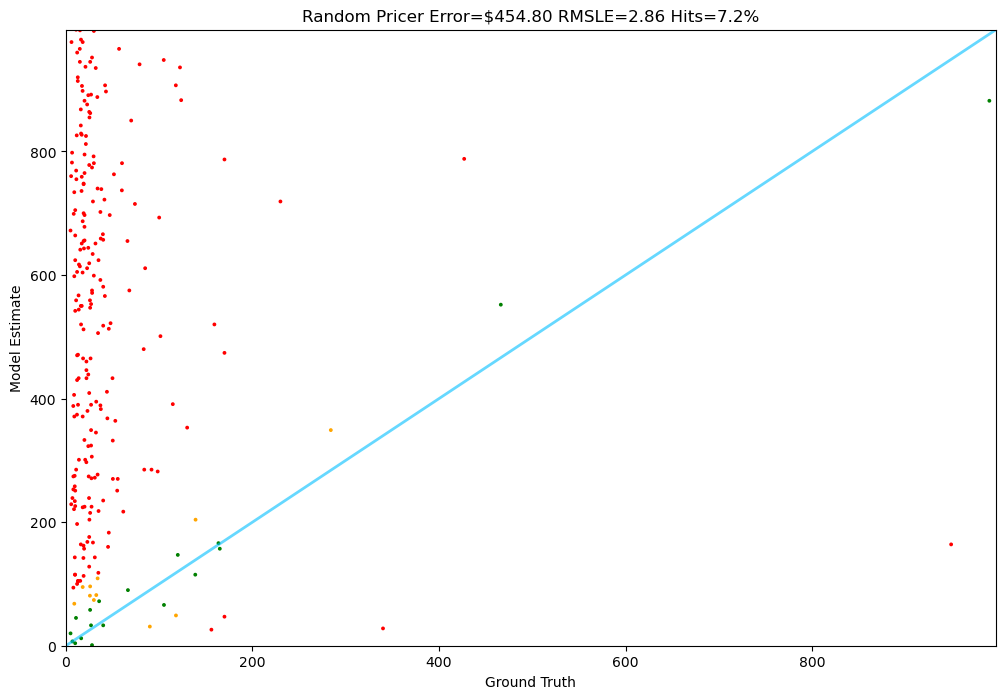

In [20]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [21]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $58.76 Truth: $65.99 Error: $7.23 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $58.76 Truth: $9.68 Error: $49.08 SLE: 2.97 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $58.76 Truth: $155.98 Error: $97.22 SLE: 0.93 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $58.76 Truth: $5.59 Error: $53.17 SLE: 4.86 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $58.76 Truth: $98.40 Error: $39.64 SLE: 0.26 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $58.76 Truth: $54.99 Error: $3.77 SLE: 0.00 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $58.76 Truth: $5.71 Error: $53.05 SLE: 4.78 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $58.76 Truth: $9.53 Error: $49.23 SLE: 3.01 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $58.76 Truth: $11.24 Error: $47.52 SLE: 2.51 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $58.76 Truth: $12.88 Error: $45.88 SLE: 2.13 Item: Away NV350

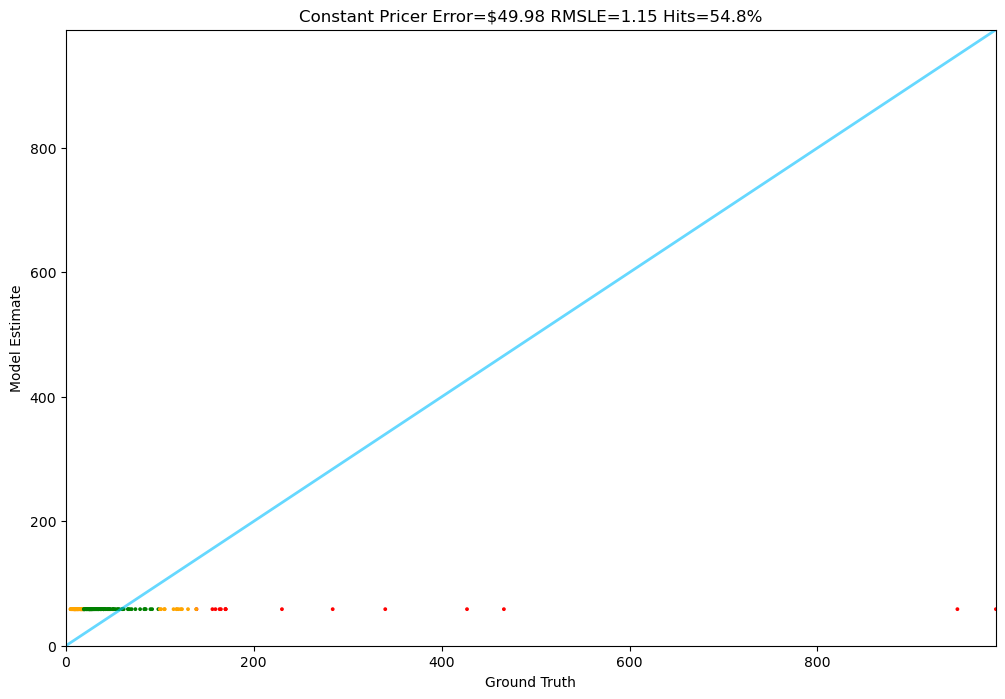

In [22]:
# Run our constant predictor
Tester.test(constant_pricer)


In [23]:
train[0].details

'{"Manufacturer": "Saffire", "Part Number": "WB31T10010 WB31T10011", "Item Weight": "1.17 pounds", "Product Dimensions": "10 x 10 x 2.5 inches", "Country of Origin": "China", "Item model number": "1854&1857", "Included Components": "Drip pans", "Batteries Included?": "No", "Batteries Required?": "No", "Warranty Description": "100% MONEYBACK GUARANTEE: We offer 100% money back guarantee with no questions asked. This great product also comes with 10-year warranty for quality related issues. Purchase with confidence and enjoy our risk-free offer", "Best Sellers Rank": {"Tools & Home Improvement": 162062, "Range Replacement Drip Pans": 144}, "Date First Available": "October 19, 2022"}'

In [24]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [25]:
train[0].features.keys()

dict_keys(['Manufacturer', 'Part Number', 'Item Weight', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Included Components', 'Batteries Included?', 'Batteries Required?', 'Warranty Description', 'Best Sellers Rank', 'Date First Available'])

In [26]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 23322),
 ('Best Sellers Rank', 22032),
 ('Item Weight', 19910),
 ('Item model number', 17497),
 ('Manufacturer', 16933),
 ('Part Number', 16589),
 ('Batteries Required?', 14820),
 ('Brand', 13896),
 ('Product Dimensions', 13718),
 ('Batteries Included?', 12152),
 ('Is Discontinued By Manufacturer', 9299),
 ('Color', 8932),
 ('Material', 8867),
 ('Package Dimensions', 7727),
 ('Brand Name', 6170),
 ('Included Components', 5961),
 ('Item Package Quantity', 5508),
 ('Country of Origin', 5105),
 ('Model Info', 4653),
 ('Special Features', 3284),
 ('Shape', 3157),
 ('Number of Pieces', 3136),
 ('Special Feature', 3131),
 ('Material Type', 2764),
 ('Style', 2686),
 ('Voltage', 2501),
 ('Size', 2405),
 ('Item Dimensions LxWxH', 2346),
 ('Unit Count', 2088),
 ('External Testing Certification', 1959),
 ('Compatible Devices', 1888),
 ('Finish Type', 1874),
 ('Warranty Description', 1778),
 ('Capacity', 1737),
 ('Number of Items', 1405),
 ('Duration', 1329),
 ('Power Sou

In [27]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [28]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [29]:
average_weight = sum(weights)/len(weights)
average_weight

3.9558465173350643

In [30]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [31]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [32]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

238325.0414017561

In [33]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [34]:
def get_text_length(item):
    return len(item.test_prompt())

In [35]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('Upstart Battery', 483),
 ('GE', 480),
 ('Whirlpool', 466),
 ('Frigidaire', 406),
 ('Supplying Demand', 277),
 ('UpStart Components', 198),
 ('SAMSUNG', 182),
 ('BlueStars', 158),
 ('Supco', 134),
 ('ICEPURE', 133),
 ('LG', 121),
 ('Broan-NuTone', 98),
 ('Lifetime Appliance Parts', 89),
 ('AMI PARTS', 88),
 ('PartsBroz', 82),
 ('Waterdrop', 77),
 ('Swift Green Filters', 71),
 ('Beaquicy', 71),
 ('Air Filter Factory', 67),
 ('Nostalgic Warehouse', 66),
 ('Generic', 65),
 ('Electrolux', 62),
 ('PUREPLUS', 58),
 ('Melitta', 57),
 ('HQRP', 56),
 ('Wowfeel', 55),
 ('Empava', 55),
 ('Aqua Fresh', 53),
 ('Edgewater Parts', 49),
 ('Tier1', 48),
 ('AQUA CREST', 48),
 ('COSTWAY', 47),
 ('Refresh', 47),
 ('Denali Pure', 46),
 ('BUNN', 46),
 ('BRBHOM', 44),
 ('GOLDEN ICEPURE', 44),
 ('EXCELPURE', 43),
 ('Seentech', 42),
 ('Range Kleen', 41)]

In [40]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [41]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [42]:
# Look at features in a training item
get_features(train[0])

{'weight': 1.17,
 'rank': 81103.0,
 'text_length': 703,
 'is_top_electronics_brand': 0}

In [43]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [44]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 4.993566084068222
rank: -1.4753193495317899e-05
text_length: 0.034373937543311577
is_top_electronics_brand: 5.96576248526473
Intercept: 15.561992621832836
Mean Squared Error: 3988.535304967167
R-squared Score: 0.6053483396480467


In [45]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $65.85 Truth: $65.99 Error: $0.14 SLE: 0.00 Item: Setpower Insulated Protective Cover for ...
2: Guess: $54.80 Truth: $9.68 Error: $45.12 SLE: 2.73 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $59.64 Truth: $155.98 Error: $96.34 SLE: 0.90 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $41.33 Truth: $5.59 Error: $35.74 SLE: 3.46 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $43.62 Truth: $98.40 Error: $54.78 SLE: 0.64 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $43.55 Truth: $54.99 Error: $11.44 SLE: 0.05 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $60.98 Truth: $5.71 Error: $55.27 SLE: 4.94 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $40.62 Truth: $9.53 Error: $31.09 SLE: 1.89 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $36.66 Truth: $11.24 Error: $25.42 SLE: 1.26 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $36.32 Truth: $12.88 Error: $23.44 SLE: 0.98 Item: Away NV35

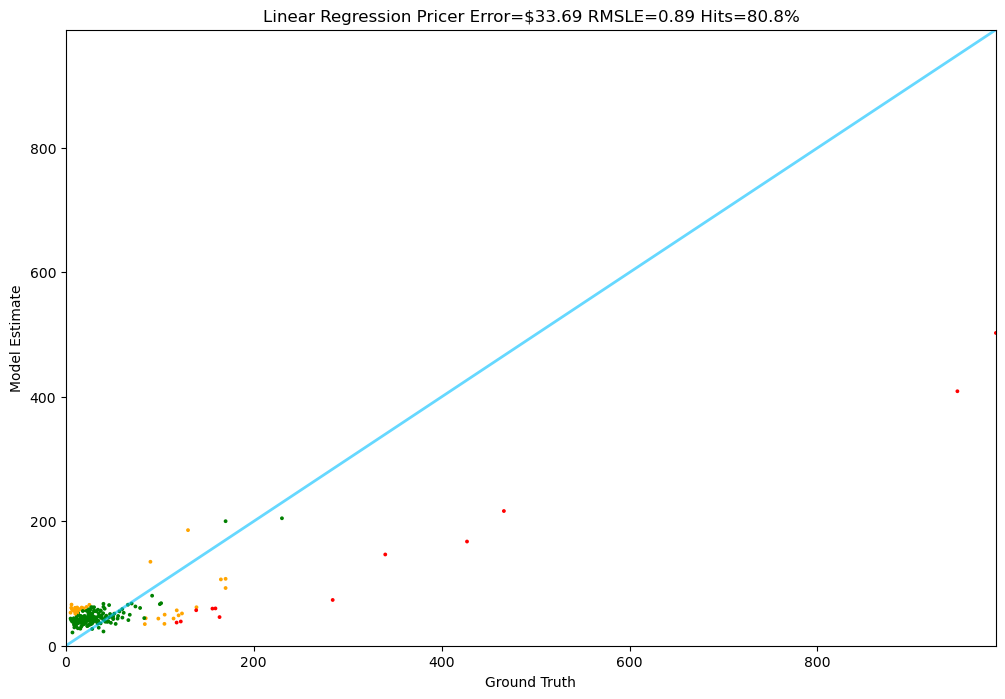

In [46]:
# test it

Tester.test(linear_regression_pricer)

In [47]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [48]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [49]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $26.13 Truth: $65.99 Error: $39.86 SLE: 0.82 Item: Setpower Insulated Protective Cover for ...
2: Guess: $36.82 Truth: $9.68 Error: $27.14 SLE: 1.60 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $77.52 Truth: $155.98 Error: $78.46 SLE: 0.48 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $29.89 Truth: $5.59 Error: $24.30 SLE: 2.39 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $156.96 Truth: $98.40 Error: $58.56 SLE: 0.21 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $0.00 Truth: $54.99 Error: $54.99 SLE: 16.20 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $0.00 Truth: $5.71 Error: $5.71 SLE: 3.62 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $31.10 Truth: $9.53 Error: $21.57 SLE: 1.24 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $33.25 Truth: $11.24 Error: $22.01 SLE: 1.06 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $108.18 Truth: $12.88 Error: $95.30 SLE: 4.25 Item: Away NV3

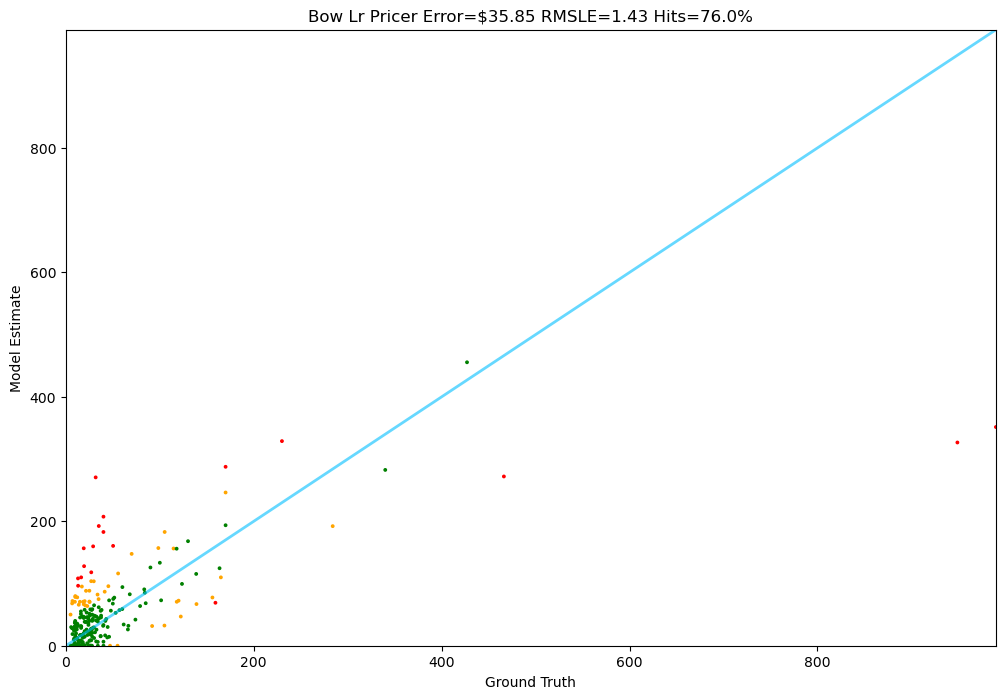

In [51]:
# test it

Tester.test(bow_lr_pricer)

In [52]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [53]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [54]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [55]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $73.56 Truth: $65.99 Error: $7.57 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $53.65 Truth: $9.68 Error: $43.97 SLE: 2.67 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $166.69 Truth: $155.98 Error: $10.71 SLE: 0.00 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $84.94 Truth: $5.59 Error: $79.35 SLE: 6.60 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $126.60 Truth: $98.40 Error: $28.20 SLE: 0.06 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $52.05 Truth: $54.99 Error: $2.94 SLE: 0.00 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $37.77 Truth: $5.71 Error: $32.06 SLE: 3.08 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $1.32 Truth: $9.53 Error: $8.21 SLE: 2.29 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $27.15 Truth: $11.24 Error: $15.91 SLE: 0.69 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $91.63 Truth: $12.88 Error: $78.75 SLE: 3.60 Item: Away NV350

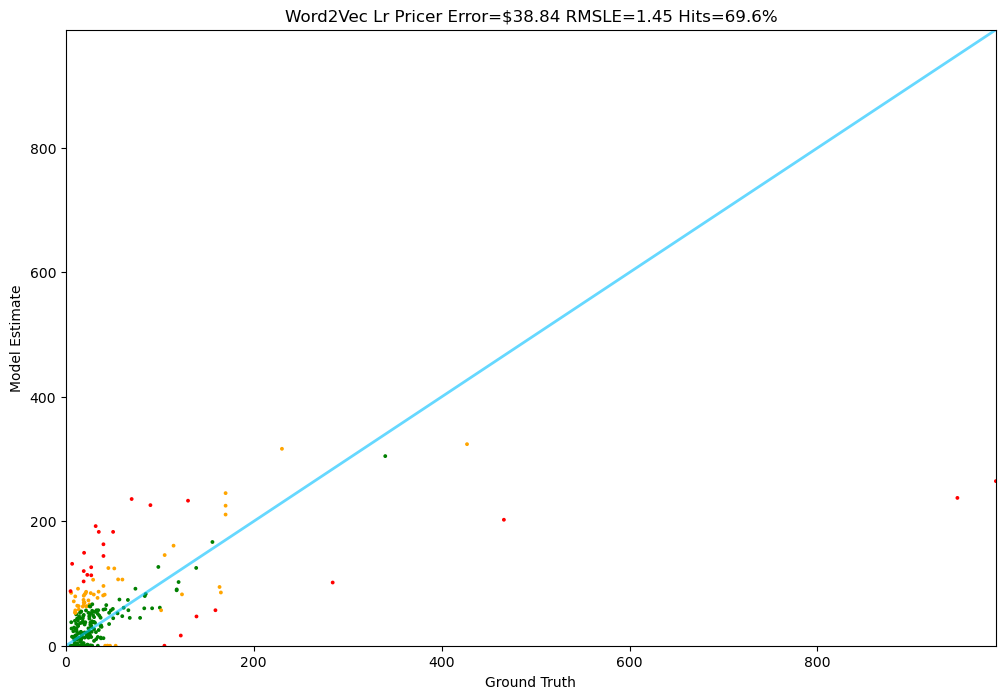

In [56]:
Tester.test(word2vec_lr_pricer)

In [57]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [58]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $41.13 Truth: $65.99 Error: $24.86 SLE: 0.22 Item: Setpower Insulated Protective Cover for ...
2: Guess: $31.29 Truth: $9.68 Error: $21.61 SLE: 1.22 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $40.22 Truth: $155.98 Error: $115.76 SLE: 1.79 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $27.28 Truth: $5.59 Error: $21.69 SLE: 2.12 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $112.41 Truth: $98.40 Error: $14.01 SLE: 0.02 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $28.47 Truth: $54.99 Error: $26.52 SLE: 0.41 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $24.59 Truth: $5.71 Error: $18.88 SLE: 1.79 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $27.59 Truth: $9.53 Error: $18.06 SLE: 1.00 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $24.23 Truth: $11.24 Error: $12.99 SLE: 0.52 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $27.08 Truth: $12.88 Error: $14.20 SLE: 0.50 Item: Away N

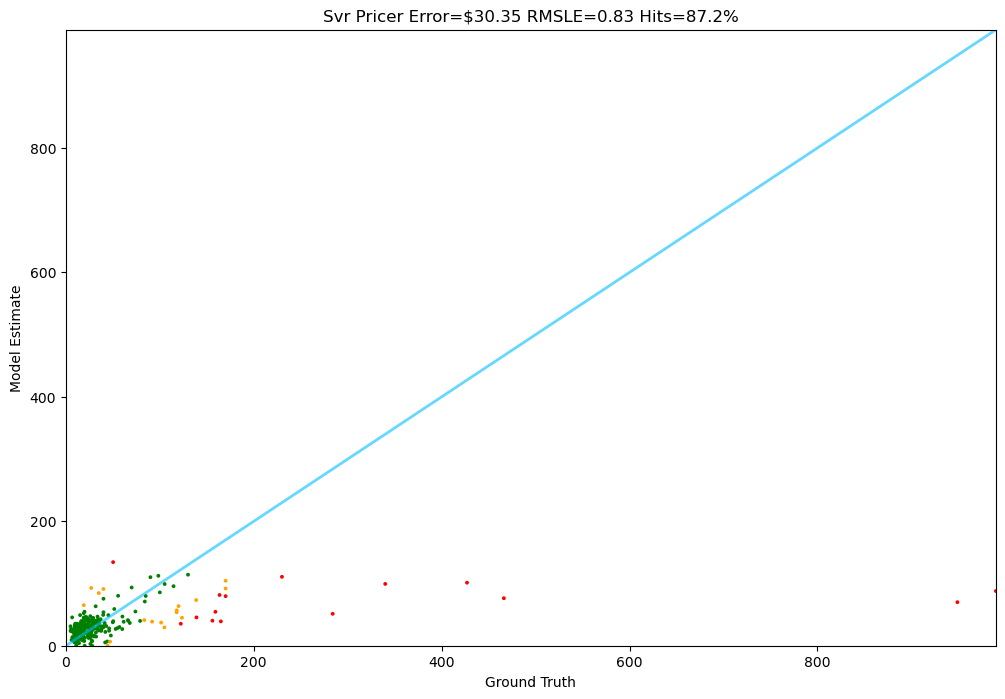

In [59]:
Tester.test(svr_pricer)

In [60]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [61]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $35.15 Truth: $65.99 Error: $30.84 SLE: 0.38 Item: Setpower Insulated Protective Cover for ...
2: Guess: $20.43 Truth: $9.68 Error: $10.75 SLE: 0.48 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $223.43 Truth: $155.98 Error: $67.45 SLE: 0.13 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $24.93 Truth: $5.59 Error: $19.34 SLE: 1.88 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $187.38 Truth: $98.40 Error: $88.98 SLE: 0.41 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $211.40 Truth: $54.99 Error: $156.41 SLE: 1.78 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $43.74 Truth: $5.71 Error: $38.03 SLE: 3.60 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $48.47 Truth: $9.53 Error: $38.94 SLE: 2.39 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $13.55 Truth: $11.24 Error: $2.31 SLE: 0.03 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $61.39 Truth: $12.88 Error: $48.51 SLE: 2.26 Item: Away 

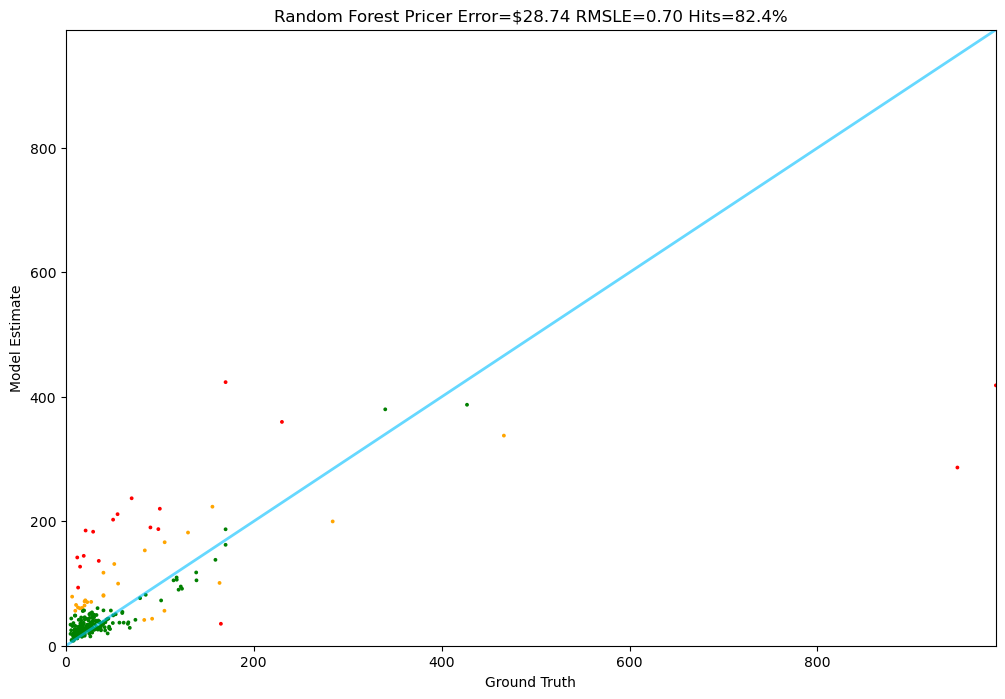

In [62]:
Tester.test(random_forest_pricer)